Preprocessing - **PCA** (component=4)  
Algorithm - **KNN Classification**  
Feature - **Magnitude** **(251)**

In [43]:
# Real + Imaginary together as one feature
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC



# Load dataset
measurement = np.load('../../dataset/meas_symm_1.npz', allow_pickle=False)
header, data = measurement['header'], measurement['data']
data_cir = data['cirs'][:1000]

# Train-test split
trainCIR, testCIR = train_test_split(data_cir, test_size=0.2, random_state=42)
print(f'trainData - {trainCIR.shape}')
print(f'testData - {testCIR.shape}')

# Define channels
alice_channel = 3  # A -> B (legitimate)
eve_channel = 6  # E -> B (illegitimate)
n_comp = 2

trainData - (800, 15, 251, 2)
testData - (200, 15, 251, 2)


In [44]:
# -------------------------------------------------- Preprocessing ------------------------------------------
def apply_pca(data, n_components):
    # data: (samples, 251, 2)
    reshaped_data = data.reshape(data.shape[0], -1)  
    print(f"reshaped_data: {reshaped_data.shape}")
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(reshaped_data)
    print(f"data_scaled: {data_scaled.shape}")
    
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data_scaled)  # (samples, n_components)
    
    return data_pca, scaler, pca

# -------- Train --------
# Feature Extraction
train_alice_cirs = trainCIR[:, alice_channel, :, :]
train_eve_cirs = trainCIR[:, eve_channel, :, :]

train_alice_mag = np.abs(train_alice_cirs[..., 0] + 1j * train_alice_cirs[..., 1])
train_eve_mag = np.abs(train_eve_cirs[..., 0] + 1j * train_eve_cirs[..., 1])

# train_alice_mag = np.sqrt(train_alice_cirs[..., 0]**2 + train_alice_cirs[..., 1]**2)
# train_alice_mag = train_alice_mag[..., np.newaxis] # (cir, 251, 1)
# train_eve_mag = np.sqrt(train_eve_cirs[..., 0]**2 + train_eve_cirs[..., 1]**2)
# train_eve_mag = train_eve_mag[..., np.newaxis] # (cir, 251, 1)

train_cirs = np.vstack((train_alice_mag, train_eve_mag)) # (cir, 251)
train_cirs_pca, scaler, pca = apply_pca(train_cirs, n_components=n_comp) # (cir, 2)
print(f'train_cirs_pca: {train_cirs_pca.shape}')

# -------- Test --------
# Feature Extraction
test_alice_cirs = testCIR[:, alice_channel, :, :]
test_eve_cirs = testCIR[:, eve_channel, :, :]

# test_alice_mag = np.sqrt(test_alice_cirs[..., 0]**2 + test_alice_cirs[..., 1]**2)
# test_alice_mag = test_alice_mag[..., np.newaxis] # (cir, 251, 1)
# test_eve_mag = np.sqrt(test_eve_cirs[..., 0]**2 + test_eve_cirs[..., 1]**2)
# test_eve_mag = test_eve_mag[..., np.newaxis] # (cir, 251, 1)

test_alice_mag = np.abs(test_alice_cirs[..., 0] + 1j * test_alice_cirs[..., 1])
test_eve_mag = np.abs(test_eve_cirs[..., 0] + 1j * test_eve_cirs[..., 1]) # (cir, 251)
test_cirs = np.vstack((test_alice_mag, test_eve_mag)) # (cir, 251)
print(f'test_cirs: {test_cirs.shape}')

# Scale
test_cirs_scaled = scaler.transform(test_cirs)
print(f'test_cirs_scaled: {test_cirs_scaled.shape}')
# PCA
test_cirs_pca = pca.transform(test_cirs_scaled)
print(f'test_cirs_pca: {test_cirs_pca.shape}')

# ----------- Labels -----------
# train
train_alice_labels = np.zeros(train_alice_cirs.shape[0])
train_eve_labels = np.ones(train_eve_cirs.shape[0])
train_labels = np.hstack((train_alice_labels, train_eve_labels)) # (cir,) -> (1600,)
# test
test_alice_label = np.zeros(test_alice_cirs.shape[0])
test_eve_labels = np.ones(test_eve_cirs.shape[0])
test_labels = np.hstack((test_alice_label, test_eve_labels))


reshaped_data: (1600, 251)
data_scaled: (1600, 251)
train_cirs_pca: (1600, 2)
test_cirs: (400, 251)
test_cirs_scaled: (400, 251)
test_cirs_pca: (400, 2)


In [45]:

# ----------------- Classification -----------------

# Initialize and train the SVM classifier
classifier = SVC(kernel='rbf', random_state=42)
classifier.fit(train_cirs_pca, train_labels)

# Predict on test data
predictions = classifier.predict(test_cirs_pca)



In [46]:
# ----------------- Evaluation -----------------
# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_labels, predictions, labels=[0, 1]).ravel()

print(f"tp: {tp}")
print(f"tn: {tn}")
print(f"fp: {fp}")
print(f"fn: {fn}")

# Missed Detection Rate (MDR)
MDR = fp / (fp + tn) if (fp + tn) > 0 else 0

# False Alarm Rate (FAR)
FAR = fn / (fn + tp) if (fn + tp) > 0 else 0

# Gamma calculation
gamma = (tp + fn) / (tn + fp) if (tn + fp) > 0 else 0

# Authentication Rate (AR)
denominator = (tp + fn) + gamma * (tn + fp)
AR = (tp + gamma * tn) / denominator if denominator > 0 else 0

print(f"MDR: {MDR}")
print(f"FAR: {FAR}")
print(f"AR: {AR}")

Classification Accuracy: 70.75%
tp: 158
tn: 125
fp: 75
fn: 42
MDR: 0.375
FAR: 0.21
AR: 0.7075


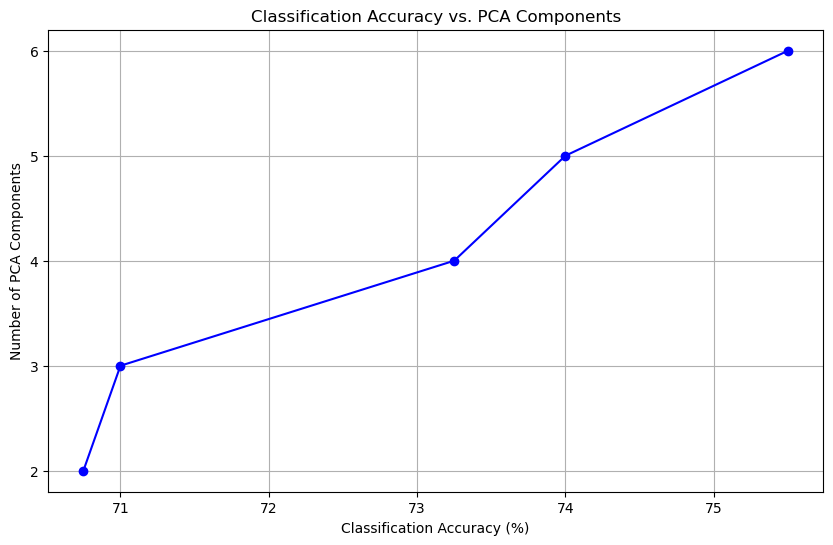

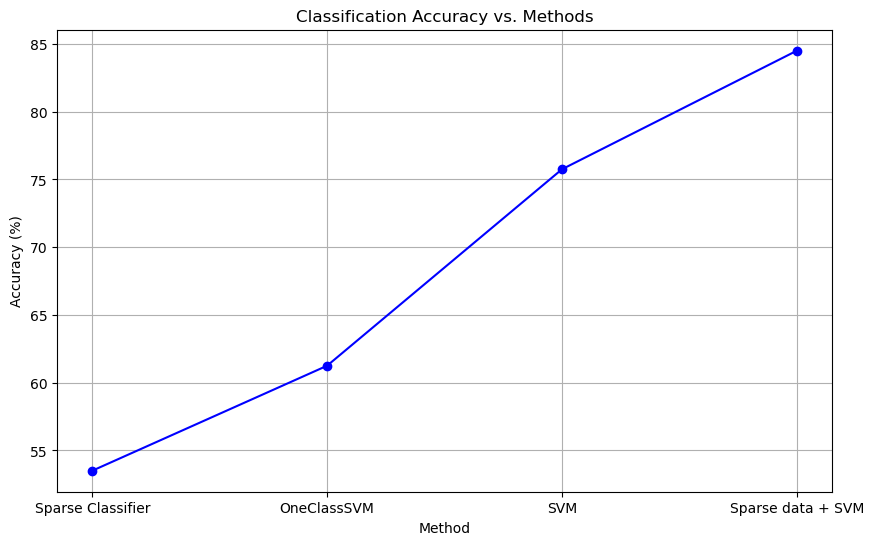

In [47]:
import matplotlib.pyplot as plt
accu = [70.75, 71.00, 73.25, 74.00, 75.50]
comp = [2, 3, 4, 5, 6]

plt.figure(figsize=(10, 6))
plt.plot(accu, comp, marker='o', linestyle='-', color='b')
plt.xlabel('Classification Accuracy (%)')
plt.ylabel('Number of PCA Components')
plt.title('Classification Accuracy vs. PCA Components')
plt.yticks(comp)  # Set y-axis ticks to match the components values
plt.grid(True)
plt.show()

method = ["Sparse Classifier", "OneClassSVM", "SVM", "Sparse data + SVM"]
acc = [53.50, 61.25, 75.75, 84.50]

plt.figure(figsize=(10, 6))
plt.plot(method, acc, marker='o', linestyle='-', color='b')
plt.xlabel('Method')
plt.ylabel('Accuracy (%)')
plt.title('Classification Accuracy vs. Methods')
# plt.yticks(acc)  # Set y-axis ticks to match the components values
plt.grid(True)
plt.show()